In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)    # resize plots

from scipy import stats

from blueice.source import Source
from blueice.model import Model
from blueice.inference import plot_likelihood_ratio, bestfit_scipy
from blueice.test_helpers import GaussianSource, test_conf

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
m = Model(test_conf())
m.expected_events()

array([1000])

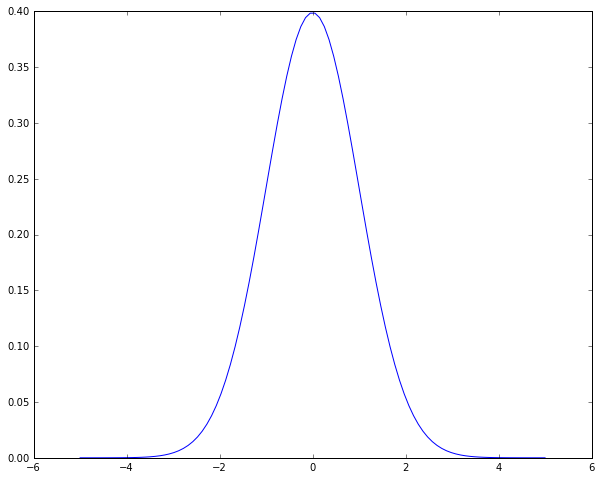

In [3]:
q = np.linspace(-5, 5, 100)
plt.plot(q, m.sources[0].pdf(q))

In [4]:
from blueice.likelihood import LogLikelihood
lf = LogLikelihood(test_conf())
lf.add_shape_parameter('some_multiplier', (0.5, 1, 2))
lf.add_rate_parameter('s0')
lf.prepare()
d = lf.base_model.simulate()
print(len(d), lf.base_model.expected_events())
lf.set_data(d)

1031 [1000]


In [5]:
for k, m in lf.anchor_models.items():
    print(k, m.expected_events(), m.sources[0].events_per_day, m.sources[0].fraction_in_range)

(0.5,) [ 500.] 500.0 1
(1.0,) [1000] 1000 1
(2.0,) [2000] 2000 1


(0.5, 2)

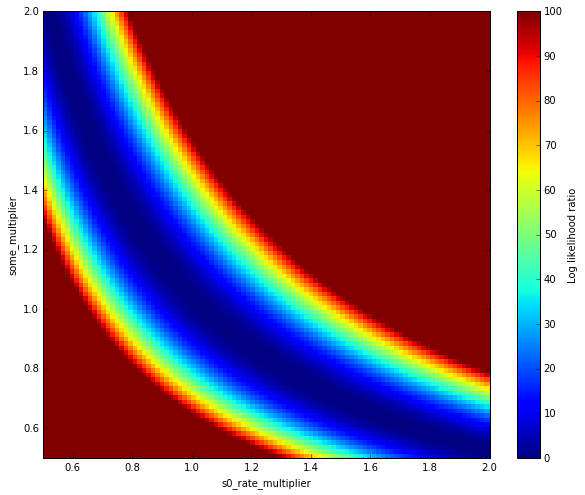

In [6]:
x = np.linspace(0.5, 2, 100)
plot_likelihood_ratio(lf, ('s0_rate_multiplier', x), ('some_multiplier', x), vmax=100)
plt.xlim(0.5, 2)
plt.ylim(0.5, 2)

(-1, 5)

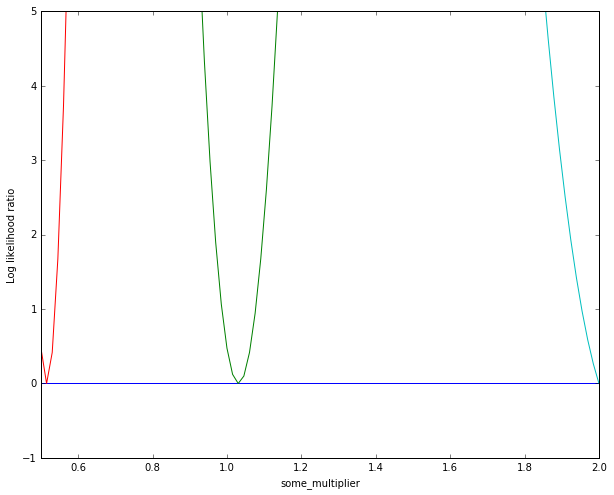

In [7]:
# Should be flat 0 (since fitting foo_rate_multiplier completely compensates for some_multiplier)
plot_likelihood_ratio(lf, ('some_multiplier', x))

# Should be centered at 1 (approximately, depends on len(d)):
plot_likelihood_ratio(lf, ('some_multiplier', x), s0_rate_multiplier=1)

# Should be centered at 0.5:
plot_likelihood_ratio(lf, ('some_multiplier', x), s0_rate_multiplier=2)

# Should be centered at 2
plot_likelihood_ratio(lf, ('some_multiplier', x), s0_rate_multiplier=0.5)
plt.ylim(-1, 5)

(-1, 5)

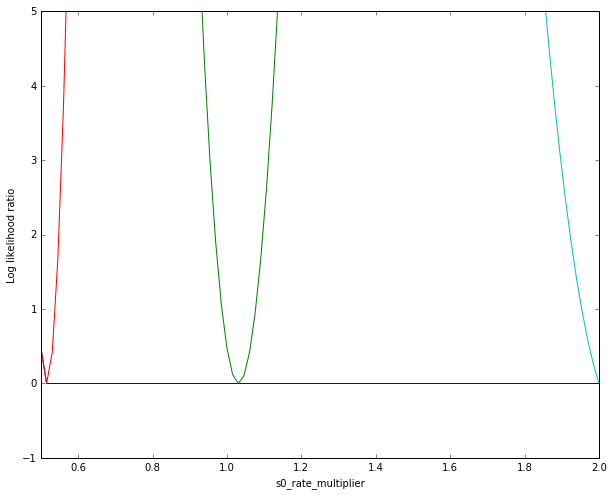

In [8]:
# Should be flat 0....
# Except when len(d) deviates significantly from 1000, 
# in which case you'll see it following the light blue/red curve.
# Unlike the rate multiplier, the shape parameter is bounded by the anchors we put in, so it can't take a value
# outside (0.5, 2).
plot_likelihood_ratio(lf, ('s0_rate_multiplier', x))

# Should be centered at 1
plot_likelihood_ratio(lf, ('s0_rate_multiplier', x), some_multiplier=1)

# Should be centered at 0.5
plot_likelihood_ratio(lf, ('s0_rate_multiplier', x), some_multiplier=2)

# Should be centered at 2:
plot_likelihood_ratio(lf, ('s0_rate_multiplier', x), some_multiplier=0.5)
plt.xlim(0.5, 2)
plt.ylim(-1, 5)

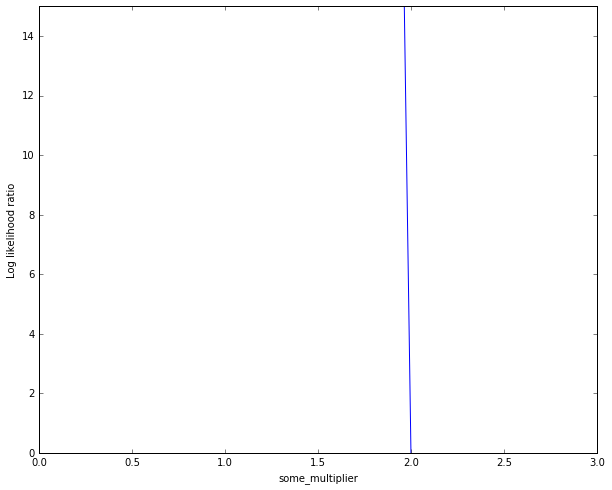

In [9]:
# Will be centered at 2, and very steep. 
# It would like to go to 10, but can't because of the bounds on the shape param
plot_likelihood_ratio(lf, ('some_multiplier', np.linspace(0, 3, 100)), s0_rate_multiplier=0.1)

# More rate-shape parameter checks

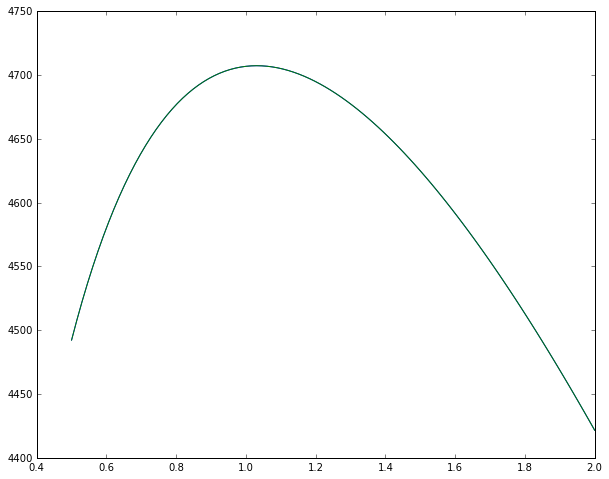

In [10]:
# Should be exactly the same:
plt.plot(x, [lf(some_multiplier=q) for q in x])
plt.plot(x, [lf(s0_rate_multiplier=q) for q in x])

In [11]:
from blueice.inference import make_objective
w1 = make_objective(lf, some_multiplier=0.6)
w2 = make_objective(lf, s0_rate_multiplier=0.6)
print(w1, "\n", w2)
f1 = w1[0]
f2 = w2[0]

(<function make_objective.<locals>.objective at 0x7fe995d7d950>, ['s0_rate_multiplier'], array([1]), [(0, None)]) 
 (<function make_objective.<locals>.objective at 0x7fe995d7d8c8>, ['some_multiplier'], array([1]), [(0.5, 2)])


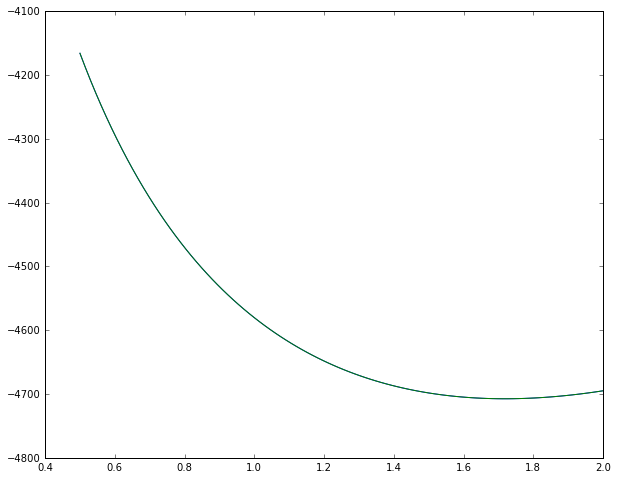

In [12]:
# Should be exactly the same
plt.plot(x, [f1([q]) for q in x])
plt.plot(x, [f2([q]) for q in x])

In [13]:
q = 0.6
kwargs = dict()
a = bestfit_scipy(lf, some_multiplier=q, **kwargs)[0]
b = bestfit_scipy(lf, s0_rate_multiplier=q, **kwargs)[0]
print(a, b, len(d)/lf.base_model.expected_events()/q)

{'s0_rate_multiplier': 1.7183333522737625} {'some_multiplier': 1.71833341645202} [ 1.71833333]
